In [11]:
# Instala bibliotecas no ambiente pelo pip
import sidrapy as sidra
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt

In [2]:
# Coleta de dados
dados_brutos = list(
    map(
        # função com 2 argumentos que será repetida
        lambda tabela, variavel: ( # lambda argumento1, argumento2: função/expressão a ser executada
            sidra.get_table(
                table_code = tabela,
                territorial_level = "1", # alguns argumentos recebem valores padrão
                ibge_territorial_code = "all",
                variable = variavel,
                classifications = { # PIB preços mercado e componentes (óticas)
                    "11255": "90687,90691,90696,90707,93404,93405,93406,93407,93408"
                    },
                period = "all"
                )
            ),

        # códigos das tabelas (pro argumento tabela)
        ["1620", "1621"],

        # códigos da variável dentro da tabela (pro argumento variavel)
        ["583", "584"]
        )
    )
# lista de DataFrames

In [3]:
# Tratamento de dados
dados = (
    pd.concat(  # empilha em uma tabela todos os DataFrames
        objs = dados_brutos,
        keys = ["num_indice", "num_indice_sa", "precos_correntes",
                "precos_constantes", "precos_constantes_sa"],
        names = ["tabela", "linha"]
        )
    .reset_index()
    .rename(columns = dados_brutos[0].iloc[0])
    # filtra na coluna Trimestre tudo que não for igual a "Trimestre" (cabeçalho)
    .query("Trimestre not in 'Trimestre'")
    .rename(
        columns = {
            "Trimestre (Código)": "data",
            "Setores e subsetores": "rubrica",
            "Valor": "valor"
            }
            )
    .filter(items = ["tabela", "data", "rubrica", "valor"], axis = "columns")
    .replace( # recodifica valores da coluna rubrica
        to_replace = {
            "rubrica": {
                "Agropecuária - total": "Agropecuária",
                "Indústria - total": "Indústria",
                "Serviços - total": "Serviços",
                "PIB a preços de mercado": "PIB",
                "Despesa de consumo das famílias": "Consumo das Famílias",
                "Despesa de consumo da administração pública": "Despesa do Governo",
                "Formação bruta de capital fixo": "FBFC",
                "Exportação de bens e serviços": "Exportação",
                "Importação de bens e serviços (-)": "Importação"
                }
                }
             )
    .assign(  # substitui o 5º caracter da coluna data por "-Q" e converte em YYYY-MM-DD
        data = lambda x: pd.to_datetime(
            x.data.str.slice_replace(start = 4, stop = 5, repl = "-Q")
            ),
        valor = lambda x: x.valor.astype(float) # converte de texto para numérico
        )
    )

dados

C:\Users\pedro\AppData\Local\Temp\ipykernel_8568\3257350502.py:3: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
C:\Users\pedro\AppData\Local\Temp\ipykernel_8568\3257350502.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


,tabela,data,rubrica,valor
1,num_indice,1996-01-01,Agropecuária,105.32
2,num_indice,1996-01-01,Indústria,93.19
3,num_indice,1996-01-01,Serviços,98.31
4,num_indice,1996-01-01,PIB,96.84
5,num_indice,1996-01-01,Consumo das Famílias,96.06
...,...,...,...,...
2031,num_indice_sa,2024-01-01,Consumo das Famílias,198.27
2032,num_indice_sa,2024-01-01,Despesa do Governo,155.96
2033,num_indice_sa,2024-01-01,FBFC,169.95
2034,num_indice_sa,2024-01-01,Exportação,371.61


In [4]:
# Calculando taxas de variação com as fórmulas expostas
taxas = (
    dados.query("tabela in ['num_indice', 'num_indice_sa'] and data >= 2012")
    .pivot(index = ["data", "rubrica"], columns = "tabela", values = "valor")
    .reset_index()
    .sort_values("data") # ordena ascedentemente pela coluna data
    )


# cria novas colunas/cálculo por grupo (rubrica) feito dentro do apply()
## Variação Marginal
taxas["var_margem"] = (
    taxas.groupby("rubrica", group_keys=False)["num_indice_sa"] # agrupa os dados e aponta a coluna
    .apply(lambda x: x.pct_change(1) * 100)   # calcula a variação na coluna
)

## Variação Interanual
taxas["var_interanual"] = (
    taxas.groupby("rubrica", group_keys=False)["num_indice"]
    .apply(lambda x: x.pct_change(4) * 100)
)

## Variação anual
taxas["var_anual"] = (
    taxas.groupby("rubrica", group_keys=False)["num_indice"] # soma móvel de 4 períodos
    .apply(lambda x: (x.rolling(4).sum() / x.rolling(4).sum().shift(4) - 1) * 100)
)

## Cria coluna de ano
taxas["ano"] = taxas["data"].dt.year

## Número índice acumulado
taxas["num_indice_acum"] = (
    taxas.groupby(["rubrica", "ano"], group_keys=False)["num_indice"]
    .apply(lambda x: x.cumsum()) # acumula o número índice por ano/rubrica
    )

## Variação acumulado no ano
taxas["var_acum_ano"] = (
    taxas.groupby("rubrica", group_keys=False)["num_indice_acum"]
    .apply(lambda x: x.pct_change(4) * 100)
)

# Renomeando as colunas
taxas = taxas.rename(columns = {
        "var_margem": "Var. % margem",
        "var_interanual": "Var. % interanual",
         "var_anual": "Var. % anual",
         "var_acum_ano": "Var. % acumulada no ano"
         }
      )

taxas

tabela,data,rubrica,num_indice,num_indice_sa,Var. % margem,Var. % interanual,Var. % anual,ano,num_indice_acum,Var. % acumulada no ano
0,2012-01-01,Agropecuária,183.52,158.88,NaN,NaN,NaN,2012,183.52,NaN
1,2012-01-01,Consumo das Famílias,167.93,170.38,NaN,NaN,NaN,2012,167.93,NaN
2,2012-01-01,Despesa do Governo,142.16,146.31,NaN,NaN,NaN,2012,142.16,NaN
3,2012-01-01,Exportação,244.15,269.95,NaN,NaN,NaN,2012,244.15,NaN
4,2012-01-01,FBFC,178.13,184.16,NaN,NaN,NaN,2012,178.13,NaN
...,...,...,...,...,...,...,...,...,...,...
435,2024-01-01,Exportação,347.90,371.61,0.180622,6.518478,8.955368,2024,347.90,6.518478
436,2024-01-01,FBFC,165.96,169.95,4.116890,2.698020,-2.692602,2024,165.96,2.698020
437,2024-01-01,Importação,271.37,280.08,6.546962,10.209966,0.774328,2024,271.37,10.209966
438,2024-01-01,Indústria,134.21,140.49,-0.120859,2.835032,1.907979,2024,134.21,2.835032


In [5]:
# Cores para gráficos
colors = {'blue': '#282f6b',
          'yellow': '#eace3f',
          'red'   : "#b22200",
          'green': '#224f20',
          'purple' : "#5f487c",
          'gray': '#666666',
          'orange' : '#b35c1e',
          'turquoise' : "#419391",
          'green_two' : "#839c56"
          }

In [17]:
# Filtra somente para o PIB
taxas_pib = (
    taxas.query("rubrica == 'PIB'")
    .filter(
        items = ["data", "Var. % margem", "Var. % interanual", "Var. % anual", "Var. % acumulada no ano"],
        axis = "columns"
        )
    .melt(id_vars = 'data')
   )
taxas_pib

,data,variable,value
0,2012-01-01,Var. % margem,NaN
1,2012-04-01,Var. % margem,1.431332
2,2012-07-01,Var. % margem,1.869604
3,2012-10-01,Var. % margem,0.040914
4,2013-01-01,Var. % margem,0.362234
...,...,...,...
191,2023-01-01,Var. % acumulada no ano,4.218434
192,2023-04-01,Var. % acumulada no ano,3.840228
193,2023-07-01,Var. % acumulada no ano,3.195637
194,2023-10-01,Var. % acumulada no ano,2.907932


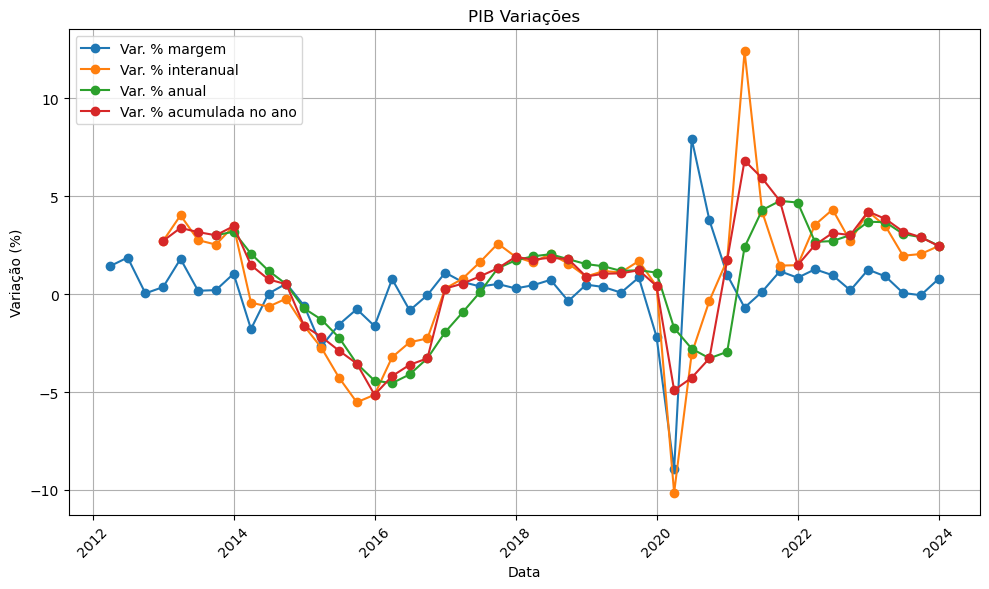

In [18]:
# Plotting
plt.figure(figsize=(10, 6))

# Iterate over unique variables and plot each
for variable in taxas_pib['variable'].unique():
    plt.plot(taxas_pib.loc[taxas_pib['variable'] == variable, 'data'],
             taxas_pib.loc[taxas_pib['variable'] == variable, 'value'],
             marker='o', label=variable)

# Formatting
plt.title('PIB Variações')
plt.xlabel('Data')
plt.ylabel('Variação (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display plot
plt.show()

In [21]:
# Tabela dos componentes do PIB (oferta)
oferta = ['Serviços', 'Indústria', "Agropecuária"]

taxas_oferta_anual = (
    taxas
    .query("rubrica in @oferta")
    .filter(
        items = ["rubrica", "data", "Var. % anual"],
        axis = "columns"
        )
    )
taxas_oferta_anual

,rubrica,data,Var. % anual
0,Agropecuária,2012-01-01,NaN
6,Indústria,2012-01-01,NaN
8,Serviços,2012-01-01,NaN
17,Serviços,2012-04-01,NaN
15,Indústria,2012-04-01,NaN
...,...,...,...
429,Indústria,2023-10-01,1.595998
423,Agropecuária,2023-10-01,15.121080
432,Agropecuária,2024-01-01,6.439273
438,Indústria,2024-01-01,1.907979


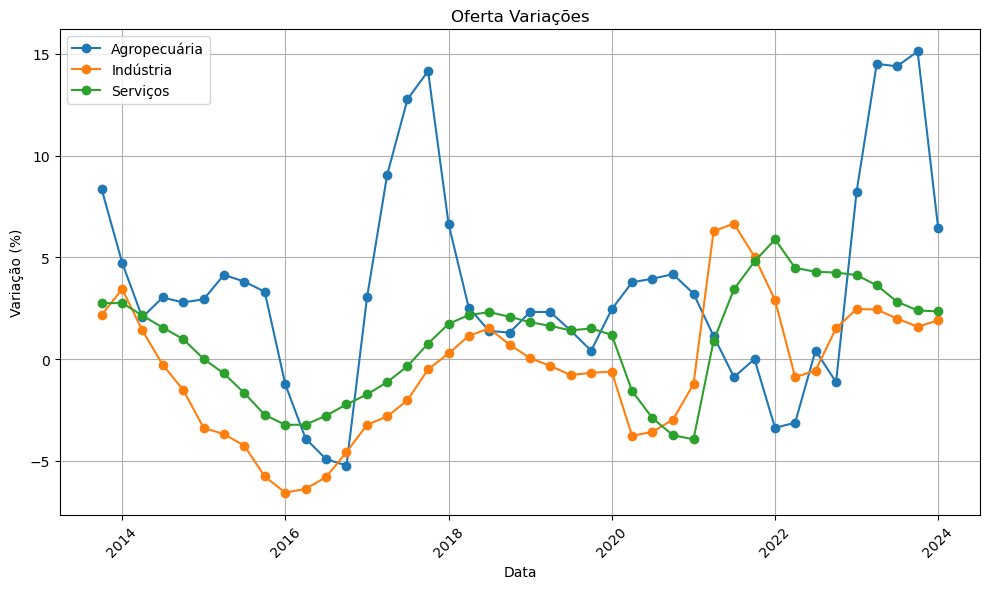

In [28]:
# Plotting
plt.figure(figsize=(10, 6))

# Iterate over unique variables and plot each
for variable in taxas_oferta_anual['rubrica'].unique():
    plt.plot(taxas_oferta_anual.loc[taxas_oferta_anual['rubrica'] == variable, 'data'],
             taxas_oferta_anual.loc[taxas_oferta_anual['rubrica'] == variable, "Var. % anual"],
             marker='o', label=variable)

# Formatting
plt.title('Oferta Variações')
plt.xlabel('Data')
plt.ylabel('Variação (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display plot
plt.show()

In [26]:
# Tabela dos componentes do PIB (demanda)
demanda = ['Consumo das Famílias', 'Despesa do Governo', "FBFC", "Exportação", "Importação"]

taxas_demanda_anual = (
    taxas
    .query("rubrica in @demanda")
    .filter(
        items = ["rubrica", "data", "Var. % anual"],
        axis = "columns"
        )
    )
taxas_demanda_anual

,rubrica,data,Var. % anual
1,Consumo das Famílias,2012-01-01,NaN
2,Despesa do Governo,2012-01-01,NaN
3,Exportação,2012-01-01,NaN
4,FBFC,2012-01-01,NaN
5,Importação,2012-01-01,NaN
...,...,...,...
433,Consumo das Famílias,2024-01-01,3.240662
434,Despesa do Governo,2024-01-01,2.148573
435,Exportação,2024-01-01,8.955368
436,FBFC,2024-01-01,-2.692602


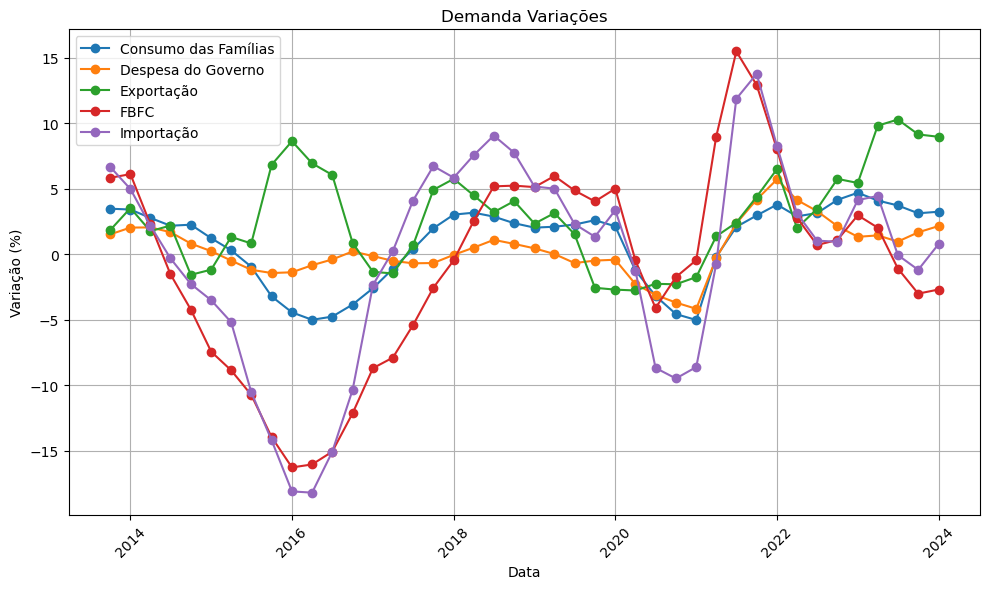

In [29]:
# Plotting
plt.figure(figsize=(10, 6))

# Iterate over unique variables and plot each
for variable in taxas_demanda_anual['rubrica'].unique():
    plt.plot(taxas_demanda_anual.loc[taxas_demanda_anual['rubrica'] == variable, 'data'],
             taxas_demanda_anual.loc[taxas_demanda_anual['rubrica'] == variable, "Var. % anual"],
             marker='o', label=variable)

# Formatting
plt.title('Demanda Variações')
plt.xlabel('Data')
plt.ylabel('Variação (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display plot
plt.show()